In [0]:
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

In [2]:
import requests
from tqdm import tqdm

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    
    with open(destination, "wb") as f:
        print('\nDownloading file...')
        for chunk in tqdm(response.iter_content(CHUNK_SIZE), unit="KB", leave=True):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
        print('File was successfully downloaded!')


file_id = '1k-1uPww4lWAQ-cQlUHmdsYTmE_J_yOTz'
destination = 'user_data.csv'
download_file_from_google_drive(file_id, destination)


129KB [00:00, 1086.40KB/s]

1544KB [00:00, 4559.28KB/s]

File was successfully downloaded!


In [3]:
user_data = pd.read_csv("user_data.csv", index_col=0)
user_data.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,gameid,username,rating
0,2105,Metro123,10.0
1,2105,BoardGamer2008,10.0
2,2105,gruenspan47,9.9
3,2105,moxtaveto,9.0
4,2105,Mazoon,9.0


In [0]:
users = user_data.username.unique()
user2id = dict(zip(users, range(len(users))))
id2user = dict((v, k) for k, v in user2id.items())

games = sorted(user_data.gameid.unique())
game2id = dict(zip(games, range(len(games))))
id2game = dict((v, k) for k, v in game2id.items())

In [5]:
user_data['userid'] = [user2id[user] for user in user_data.username]
user_data['gameid'] = [game2id[game] for game in user_data.gameid]
user_data.head()

,gameid,username,rating,userid
0,827,Metro123,10.0,0
1,827,BoardGamer2008,10.0,1
2,827,gruenspan47,9.9,2
3,827,moxtaveto,9.0,3
4,827,Mazoon,9.0,4


In [6]:
user_data.drop(columns=['username'], inplace=True)
user_data = user_data[['userid', 'gameid', 'rating']]
user_data.head()

,userid,gameid,rating
0,0,827,10.0
1,1,827,10.0
2,2,827,9.9
3,3,827,9.0
4,4,827,9.0


In [7]:
d_train, d_test = train_test_split(user_data, test_size=0.3, random_state=7)
print(len(d_train), len(d_test))

1294121 554624


In [0]:
class RatingDataset(Dataset):
    def __init__(self, user_tensor, item_tensor, rating_tensor):
        self.user_tensor = user_tensor
        self.item_tensor = item_tensor
        self.rating_tensor = rating_tensor

    def __getitem__(self, index):
        return self.user_tensor[index], self.item_tensor[index], self.rating_tensor[index]
    
    def __len__(self):
        return self.user_tensor.size(0)

In [9]:
train_dataset = RatingDataset(
    torch.tensor(d_train.userid.values, dtype=torch.long),
    torch.tensor(d_train.gameid.values, dtype=torch.long),
    torch.tensor(d_train.rating.values, dtype=torch.float)
)

print(d_train.iloc[0])
print(train_dataset[0])

userid    5138.0
gameid     815.0
rating       7.0
Name: 1204290, dtype: float64
(tensor(5138), tensor(815), tensor(7.))


In [0]:
batch_size = 1024

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [0]:
class NeuMF(nn.Module):
    def __init__(self, config):
        super(NeuMF, self).__init__()
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim_mf = config['latent_dim_mf']
        self.latent_dim_mlp = config['latent_dim_mlp']

        self.embedding_user_mlp = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mlp)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mlp)
        self.embedding_user_mf = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_mf = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config['layers'][:-1], config['layers'][1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        self.affine_output = nn.Linear(in_features=config['layers'][-1] + config['latent_dim_mf'], out_features=1)

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=1)
        mf_vector = torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = nn.ReLU()(mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.affine_output(vector)
        rating = logits
        return rating

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

config = {
    'num_users': len(user2id),
    'num_items': len(game2id),
    'latent_dim_mf': 4,
    'latent_dim_mlp': 4,
    'layers': [8, 32, 16]
}

In [0]:
neumf = NeuMF(config).to(device)
optimizer = torch.optim.Adam(neumf.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [47]:
epochs = 15

losses = []
for epoch in range(epochs):
    neumf.train()
    epoch_loss = 0
    for i, batch in enumerate(train_loader, start=1):
        users, games, ratings = batch[0].to(device), batch[1].to(device), batch[2].to(device)
        
        optimizer.zero_grad()
        
        preds = neumf(users, games)
        loss = criterion(preds.view(-1), ratings)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * preds.shape[0]
        print(f'\rBatch [{i}/{len(train_loader)}]', end='')

    epoch_loss = epoch_loss / len(train_dataset)
    print(f'\rEpoch [{epoch + 1}/{epochs}] | Avg. Loss = {epoch_loss}')
    losses.append(epoch_loss)

Epoch [1/15] | Avg. Loss = 5.501389621467295
Epoch [2/15] | Avg. Loss = 1.4656563983897113
Epoch [3/15] | Avg. Loss = 1.2045200771002769
Epoch [4/15] | Avg. Loss = 0.9761776027315117
Epoch [5/15] | Avg. Loss = 0.8728631351622766
Epoch [6/15] | Avg. Loss = 0.8144937322202657
Epoch [7/15] | Avg. Loss = 0.7685617256982689
Epoch [8/15] | Avg. Loss = 0.7304579089117601
Epoch [9/15] | Avg. Loss = 0.7001973025404565
Epoch [10/15] | Avg. Loss = 0.6761731768893269
Epoch [11/15] | Avg. Loss = 0.6573609029673745
Epoch [12/15] | Avg. Loss = 0.6426873493975687
Epoch [13/15] | Avg. Loss = 0.6310878650991147
Epoch [14/15] | Avg. Loss = 0.6214876009678889
Epoch [15/15] | Avg. Loss = 0.6132884743838807


In [0]:
torch.save(neumf.state_dict(), "drive/My Drive/rating_pred_25.pth")

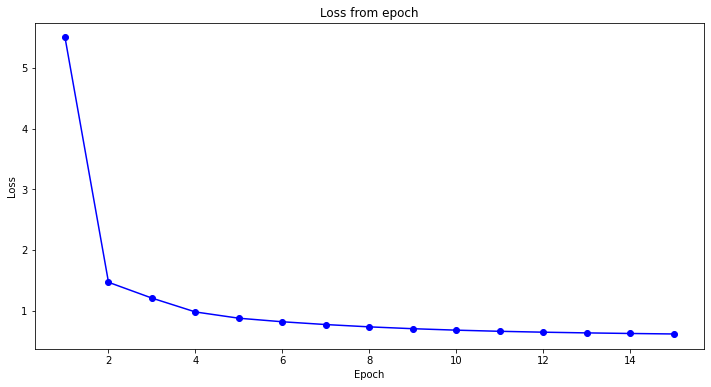

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(losses) + 1), losses, 'bo-')
plt.title('Loss from epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [52]:
neumf.eval()

test_users = torch.tensor(d_test.userid.values, dtype=torch.long).to(device)
test_games = torch.tensor(d_test.gameid.values, dtype=torch.long).to(device)
test_ratings = torch.tensor(d_test.rating.values, dtype=torch.float).to(device)

preds = neumf(test_users, test_games).view(-1)
criterion(preds, test_ratings).item()

0.7130582928657532

In [0]:
neumf.load_state_dict(torch.load("drive/My Drive/rating_pred_25.pth"))

<All keys matched successfully>

In [0]:
from sklearn.metrics import mean_absolute_error

In [54]:
neumf.eval()

total_error = 0
test_users = torch.tensor(d_test.userid.values, dtype=torch.long).to(device)
test_games = torch.tensor(d_test.gameid.values, dtype=torch.long).to(device)
test_ratings = torch.tensor(d_test.rating.values, dtype=torch.float).to(device)

preds = neumf(test_users, test_games).view(-1)
mean_absolute_error(preds.detach().cpu(), test_ratings.detach().cpu())

0.64650196